In [53]:
import os
from copy import deepcopy
from datetime import datetime
from os import listdir

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import yaml
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
plt.rcParams["figure.figsize"] = [16,9]

In [3]:
def get_conf(conf_path):
    """Reads configuration file"""
    with open(rf'{conf_path}') as conf_file:
        conf = yaml.safe_load(conf_file)
        return conf

In [4]:
def SMAPE(forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    if len(actual.shape)!=2:
        actual = actual.reshape(actual.shape[0],1)
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2

    smape_score = str(round(sum(diff/avg)/len(forecast) * 100, 2))

    print('SMAPE Error Score: ' + smape_score + ' %')
    return smape_score

In [5]:
def plot_pred_vs_act(actual, predicted, model_type):
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.legend()
    plt.title(f'Predicted vs Actual Sales for {model_type} Model')

In [6]:
def Fuller(TimeSeries):
    """Provides Fuller test results for TimeSeries"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

In [7]:
def xboost(xgb_params, xgb_model_dir, x_train=None, y_train=None, x_test=None, y_test=None, training_req=1):
    """Trains xgboost model and returns it"""

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    file_name = f'xgb_model_{folder_name}.json'

    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, label=y_test, feature_names=list(x_test.columns))

    if training_req:

        params = {'max_depth':xgb_params['XGB_MAX_DEPTH'],
                  'eta':xgb_params['XGB_ETA'],
                  'silent':xgb_params['XGB_SILENT'],
                'subsample':xgb_params['XGB_SUBSAMPLE']}
        num_rounds = xgb_params['XGB_NUM_ROUNDS']

        xgb_model = xgb.train(params, dtrain, num_rounds)

        # save
        xgb_model.save_model(xgb_model_dir+file_name)

    else:
        sorted_xgb_models = [x for x in listdir(xgb_model_dir) if 'xgb_' in str(x)]
        sorted_xgb_models.sort(reverse=True)
        xgb_model = xgb.Booster()
        xgb_model.load_model(xgb_model_dir+str(sorted_xgb_models[0]))


    return xgb_model, dtest

In [8]:
def lstm_model(params,lstm_model_dir, x_train=None, y_train=None, x_valid=None, y_valid=None, training_req=1):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if training_req:
        callback = EarlyStopping(monitor='val_loss', patience=3)
        mdl = Sequential()

        mdl.add(LSTM(params['LSTM_NODES'],
                     # activation='relu',
                     input_shape=(x_train.shape[1], x_train.shape[2]),
                     # unroll=True
                     )
                )

        # mdl.add(Dropout(0.5))

        # mdl.add(LSTM(params['LSTM_NODES']//2,
        #              activation='relu',
        #              return_sequences=False
        #              )
        #         )

        mdl.add(Dense(1))

        mdl.compile(loss='mse', optimizer='adam')

        mdl.summary()

        lstm_history = mdl.fit(
            x_train,
            y_train,
            validation_data=(x_valid, y_valid),
            epochs=conf['LSTM_PARAMS']['LSTM_EPOCHS'],
            batch_size=90,
            callbacks=callback,
            verbose=True
        )

        mdl.save(lstm_model_dir+save_path)

    else:
        fnf = listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=True)
        mdl = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    return mdl


In [9]:
def lstm_model_v2(params,lstm_model_dir, x_train=None, y_train=None, x_valid=None, y_valid=None, training_req=1):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if training_req:
        callback = EarlyStopping(monitor='val_loss', patience=3)
        model_lstm = Sequential()
        model_lstm.add(LSTM(params['LSTM_NODES'], activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
        model_lstm.add(Dropout(0.5))
        model_lstm.add(LSTM(params['LSTM_NODES']//2, activation='relu', return_sequences=False))
        model_lstm.add(Dense(1))
        model_lstm.compile(loss='mse', optimizer=optimizers.Adam(conf['LSTM_PARAMS']['LSTM_LR']))
        model_lstm.summary()
        lstm_history = model_lstm.fit(
            x_train,
            y_train,
            validation_data=(x_valid, y_valid),
            epochs=conf['LSTM_PARAMS']['LSTM_EPOCHS'],
            callbacks=callback,
            verbose=True
        )
        model_lstm.save(lstm_model_dir+save_path)

    else:
        fnf = listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=False)
        model_lstm = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    return model_lstm


In [10]:
def lstm_model_v3(params,lstm_model_dir, x_train=None, y_train=None, x_valid=None, y_valid=None, training_req=1):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if training_req:
        callback = EarlyStopping(monitor='val_loss', patience=3)
        mdl = Sequential()

        mdl.add(LSTM(params['LSTM_NODES'],
                     activation='relu',
                     batch_input_shape=(params['LSTM_BATCH_SIZE'],x_train.shape[1], x_train.shape[2]),
                     stateful=True,
                     return_sequences=True
                     )
                )

        mdl.add(Dropout(0.5))

        mdl.add(LSTM(params['LSTM_NODES']//2,
                     activation='relu',
                     return_sequences=False
                     )
                )

        mdl.add(Dense(1))

        mdl.compile(loss='mse', optimizer=optimizers.Adam(conf['LSTM_PARAMS']['LSTM_LR']))

        mdl.summary()

        lstm_history = mdl.fit(
            x_train,
            y_train,
            validation_data=(x_valid, y_valid),
            epochs=conf['LSTM_PARAMS']['LSTM_EPOCHS'],
            callbacks=callback,
            verbose=True
        )

        mdl.save(lstm_model_dir+save_path)

    else:
        fnf = listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=True)
        mdl = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    return mdl

In [11]:
def read_data(path, date_index_col, numeric_cols=None):
    if path:
        df = pd.read_csv(path, index_col=date_index_col, infer_datetime_format=True)
        df.index = pd.to_datetime(df.index)
        if numeric_cols:
            for col in numeric_cols:
                df[col] = df[col].astype('int16')
        return df

In [244]:
# Prepare data by aggregating according to config
def data_preprocessing(data, expected_cols, grouped_cols, label_col, date_col='date'):
    # Rearrange dataset so we can apply shift methods
    data = data.reset_index()

    if label_col in data.columns:
        data = data.sort_values(date_col).groupby(grouped_cols, as_index=False)
        data = data.agg({f'{label_col}':['mean']})
        data.columns = grouped_cols + [label_col]

    else:
        data = data[[c for c in expected_cols if c!=label_col]]
        data = data[grouped_cols]
        data = data.sort_values([c for c in grouped_cols if c!=label_col])
    return data


In [13]:
def xgboost_data_preprocessing(data_in,date_col):

    data = deepcopy(data_in)
    # Adding date based features
    data[date_col] = pd.to_datetime(data[date_col])
    data['year'] = data[date_col].dt.year
    data['quarter'] = data[date_col].dt.quarter
    data['month'] = data[date_col].dt.month
    data['weekofyear'] = data[date_col].dt.weekofyear
    data['weekday'] = data[date_col].dt.weekday
    data['dayofweek'] = data[date_col].dt.dayofweek


    return data

In [14]:
def feature_engineering(data_in,date_col) -> pd.DataFrame:

    data = deepcopy(data_in)
    data.index = pd.DatetimeIndex(data[date_col])

    # Adding date based features
    data[date_col] = pd.to_datetime(data[date_col], infer_datetime_format=True)
    data['year'] = data[date_col].dt.year.astype('float32')
    data['quarter'] = data[date_col].dt.quarter.astype('float32')
    data['month'] = data[date_col].dt.month.astype('float32')
    data['weekofyear'] = data.index.isocalendar().week.astype('float32')
    data['dayofweek'] = data[date_col].dt.dayofweek.astype('float32')
    data.drop(f'{date_col}', axis=1, inplace=True)
    data.reset_index(inplace=True)


    return data

In [106]:
def series_to_supervised(data, index, target, categories, lookback=1, lag=1, dropnan=True):
    """Transform the data into a time series problem"""

    # data = deepcopy(data_in)

    # Drop index column from data
    if index in data.columns:
        data.drop(f'{index}', axis=1, inplace=True)

    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(lookback, 0, -1):
        cols.append(data.shift(i))
        names += [f'{col}(t-{i})' for col in data.columns]

    # Current timestep (t=0)
    cols.append(data)
    names += [f'{col}(t)' for col in data.columns]

    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [f'{col}(t+{lag})' for col in data.columns]

    # Put it all together
    agg = pd.concat(cols, axis=1, join='inner')
    agg.columns = names

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    # Drop rows with different item or store values than the shifted columns
    last_cols_for_categories = [f'{x}(t-{lookback})' for x in categories]

    for cat in last_cols_for_categories:
        col = cat.split('(')[0] # example - item
        agg = agg[(agg[f'{col}(t+{lag})'] == agg[cat])]

    return agg

In [175]:
def series_to_supervised_forecast(data, index, target, categories, lookback=1, lag=1):
    """Transform the data into a time series problem"""

    # data = deepcopy(data_in)

    # Drop index column from data
    if index in data.columns:
        data.drop(f'{index}', axis=1, inplace=True)

    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(lookback, 0, -1):
        cols.append(data.shift(i))
        names += [f'{col}(t-{i})' for col in data.columns]

    # Current timestep (t=0)
    cols.append(data)
    names += [f'{col}(t)' for col in data.columns]

    # Target timestep (t=lag)
    cols.append(data)
    names += [f'{col}(t+{lag})' for col in data.columns]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with different item or store values than the shifted columns
    last_cols_for_categories = [f'{x}(t-{lookback})' for x in categories]

    for cat in last_cols_for_categories:
        col = cat.split('(')[0] # example - item
        agg = agg[(agg[f'{col}(t)'] == agg[cat])]

    # Putting 0s in (t+lag) column
    agg[f'{target}(t+{lag})'] = 0
    return agg

In [16]:
def split_train_valid(data, label, test_size, lag):

    # Label
    labels_col = f'{label}(t+{lag})'
    labels = data[labels_col]
    data = data.drop([x for x in data.columns if '+' in str(x)], axis=1)

    X_train, X_valid, Y_train, Y_valid = train_test_split(data, labels.values, test_size=test_size, shuffle=False)

    return X_train, Y_train, X_valid, Y_valid

In [17]:
def split_xy(data, data_cols, label_col):
    # labels_col = f'{label}(t+{lag})'
    label_pos = data_cols.index(label_col) + 1
    col_len = len(data_cols)
    act_len = col_len-1 #Removing index
    label_index = data.shape[1] - (act_len - label_pos) - 2
    labels = data[:,label_index]
    data = data[:,:data.shape[1] - act_len] #Removing target columns
    return data,labels

In [18]:
def reshape_features(X_train,X_valid, lookback, features):
    X_train_series = X_train.reshape((X_train.shape[0], lookback+1, features))
    X_valid_series = X_valid.reshape((X_valid.shape[0], lookback+1, features))
    return X_train_series, X_valid_series

In [19]:
def data_scaler(data, scaled, inverse=False, model=None):
    if scaled:
        fitted_scaler = joblib.load(OBJECTS_DIR+model+SCALER_FILE)

        if inverse:
            inv_scaled_data = fitted_scaler.inverse_transform(data)
            return inv_scaled_data
        else:
            scaled_data = fitted_scaler.transform(data)
            return scaled_data

    else:
        scaler = StandardScaler()
        # num_cols = [x for x in data.columns if num_col in x]
        scaled_data = scaler.fit_transform(data)
        joblib.dump(scaler, OBJECTS_DIR+model+SCALER_FILE)
        return scaled_data

In [20]:
def category_wise_split_train_eval(data, categories, eval_len):
    split_train = []
    split_test = []
    for i, frame in data.groupby(categories):
        split_train.append(frame[:-eval_len])
        split_test.append(frame[-eval_len:])

    train = pd.concat(split_train, axis=0)
    eval = pd.concat(split_test, axis=0)

    return train, eval

In [183]:
def get_last_n_days_data(data, gp_cols, lookback,lag):
    sections = []
    index_name = data.index.name

    for i, frame in data.groupby(data.index):
        sections.append(frame)

    elements_num = len(sections)
    sections = sections[-(lookback+lag):]

    sections_df = pd.concat(sections, axis=0)
    sections_df = sections_df.reset_index().sort_values(gp_cols).set_index(index_name)

    return sections_df

In [93]:
MAIN_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])
RAW_DATA_DIR = os.path.join(MAIN_DIR, 'data', 'raw', 'store_item', '')
PROCESSED_DATA_DIR = os.path.join(MAIN_DIR, 'data','processed', '')
MODEL_DIR = os.path.join(MAIN_DIR, 'models', '')
OBJECTS_DIR = os.path.join(MAIN_DIR, 'objects', '')
CONFIGS_PATH = os.path.join(MAIN_DIR, 'configs', 'config.yaml')
conf = get_conf(CONFIGS_PATH)

SCALER_FILE = 'lag1_scaler_info.save'
TRAIN_PATH = RAW_DATA_DIR + 'train.csv'
TEST_PATH = RAW_DATA_DIR + 'test.csv'
PROCESSED_PATH = PROCESSED_DATA_DIR + 'data.csv'

NP_ARRAYS_NAMES = ['X_train_series', 'Y_train', 'X_valid_series', 'Y_valid']

plt.rcParams["figure.figsize"] = [16,9]

In [214]:
# Read Training and Testing data
train = read_data(TRAIN_PATH, 0, conf['NUMERIC_COLS'])
test = read_data(TEST_PATH, 1)

<h1> LSTM </h1>

In [25]:
train_set, eval_set = category_wise_split_train_eval(train, conf['CATEGORIES'], eval_len=360)

In [29]:
# Convert data into format fit for LSTM
seq_train_set = series_to_supervised(train_set,
                                             index=conf['INDEX_COL'],
                                             target=conf['LABEL_COL'],
                                             categories=conf['CATEGORIES'],
                                             lookback=conf['LSTM_PARAMS']['LSTM_LOOKBACK'],
                                             lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                             )

In [31]:
# Convert data into format fit for LSTM
seq_eval_set = series_to_supervised(eval_set,
                                     index=conf['INDEX_COL'],
                                     target=conf['LABEL_COL'],
                                     categories=conf['CATEGORIES'],
                                     lookback=conf['LSTM_PARAMS']['LSTM_LOOKBACK'],
                                     lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                     )

In [33]:
# Scale data for training
train_scaled = data_scaler(seq_train_set, scaled=0, model='lstm')
eval_scaled = data_scaler(seq_eval_set, scaled=1, model='lstm')

In [36]:
# Split train eval into x & y
x_train, y_train = split_xy(train_scaled, conf['DATA_COLS'], conf['LABEL_COL'])
x_eval, y_eval = split_xy(eval_scaled, conf['DATA_COLS'], conf['LABEL_COL'])

In [38]:
# Reshape data for training
x_train_reshaped, x_eval_reshaped = reshape_features(x_train,
                                                     x_eval,
                                                     lookback=conf['LSTM_PARAMS']['LSTM_LOOKBACK'],
                                                     features=len(conf['GROUPED_COLS']))

In [41]:
y_train_reshaped, y_eval_reshaped = y_train.reshape((y_train.shape[0], 1)), y_eval.reshape((y_eval.shape[0], 1))

In [42]:
# Obtain trained LSTM model
model_lstm = lstm_model(conf['LSTM_PARAMS'],
                        MODEL_DIR,
                        x_train_reshaped,
                        y_train_reshaped,
                        x_eval_reshaped,
                        y_eval_reshaped,
                        training_req=1
                        )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7150/7150 [==============================] - 60s 8ms/step - loss: 0.2116 - val_loss: 0.1441
Epoch 2/10
7150/7150 [==============================] - 55s 8ms/step - loss: 0.1401 - val_loss: 0.1585
Epoch 3/10
7150/7150 [==============================] - 57s 8ms/step - loss: 0.1333 - val_loss: 0.1329
Epoch 4/10
7150/7150 [==============================] - 56s 8ms/step - loss: 0.1305 - val_loss: 0.1309
Epoch 5/10
7150/7150 [==============

INFO:tensorflow:Assets written to: C:\Users\yashc\DataspellProjects\EnsembleDemandForecasting\models\model-07-04-2022-18-55-33\assets


INFO:tensorflow:Assets written to: C:\Users\yashc\DataspellProjects\EnsembleDemandForecasting\models\model-07-04-2022-18-55-33\assets


In [45]:
# Making predictions with eval data
pred = model_lstm.predict(x_eval_reshaped)


2829/2829 [==============================] - 10s 3ms/step


In [46]:
# Inverse scaling predictions and calculating SMAPE
eval_with_pred = np.concatenate((eval_scaled[:,:-1], pred), axis=1)
eval_with_pred = data_scaler(eval_with_pred, scaled=1, inverse=True, model='lstm')

In [49]:
inv_pred = eval_with_pred[:,-1].reshape(-1,1)
inv_eval_y = seq_eval_set.iloc[:,-1].values.reshape(-1,1)
lstm_smape = SMAPE(inv_pred, inv_eval_y)

SMAPE Error Score: 13.85 %


In [50]:
# LSTM Evaluation - MSE
lstm_mse = model_lstm.evaluate(x_eval_reshaped,eval_scaled[:,-1].reshape(-1,1))

2829/2829 [==============================] - 11s 4ms/step - loss: 0.1188


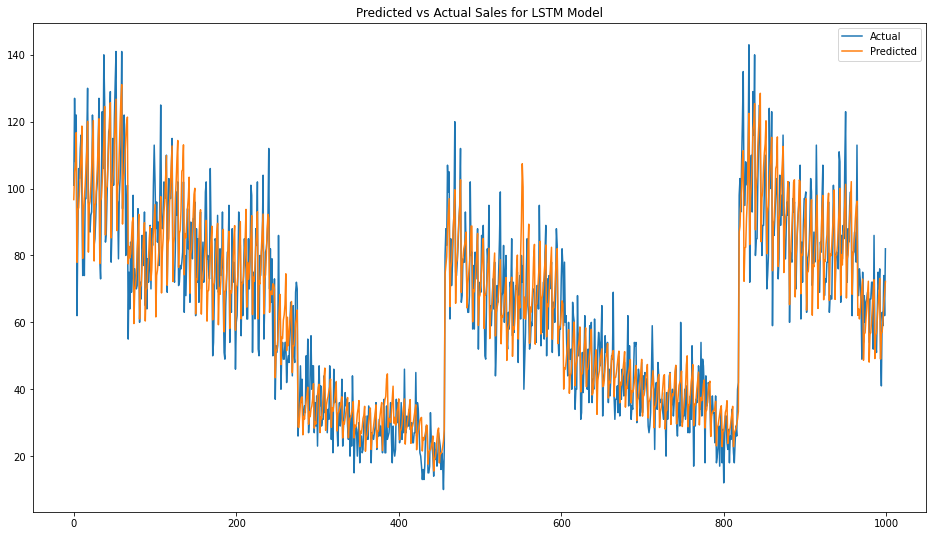

In [54]:
plot_pred_vs_act(inv_eval_y[-1000:],inv_pred[-1000:],'LSTM')

In [52]:
pred_df = pd.DataFrame(eval_with_pred, columns=seq_eval_set.columns, index=seq_eval_set.index)
pred_df

,store(t-89),item(t-89),sales(t-89),store(t-88),item(t-88),sales(t-88),store(t-87),item(t-87),sales(t-87),store(t-86),...,sales(t-2),store(t-1),item(t-1),sales(t-1),store(t),item(t),sales(t),store(t+90),item(t+90),sales(t+90)
date,,,,,,,,,,,,,,,,,,,,,
2017-04-05,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,...,17.0,1.0,1.0,22.0,1.0,1.0,21.0,1.0,1.0,21.344490
2017-04-06,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,...,22.0,1.0,1.0,21.0,1.0,1.0,25.0,1.0,1.0,21.698002
2017-04-07,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,...,21.0,1.0,1.0,25.0,1.0,1.0,25.0,1.0,1.0,24.592739
2017-04-08,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,...,25.0,1.0,1.0,25.0,1.0,1.0,23.0,1.0,1.0,25.785433
2017-04-09,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,...,25.0,1.0,1.0,23.0,1.0,1.0,20.0,1.0,1.0,25.671791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-28,10.0,50.0,119.0,10.0,50.0,120.0,10.0,50.0,99.0,10.0,...,79.0,10.0,50.0,80.0,10.0,50.0,82.0,10.0,50.0,57.196411
2017-09-29,10.0,50.0,120.0,10.0,50.0,99.0,10.0,50.0,98.0,10.0,...,80.0,10.0,50.0,82.0,10.0,50.0,90.0,10.0,50.0,60.721752
2017-09-30,10.0,50.0,99.0,10.0,50.0,98.0,10.0,50.0,103.0,10.0,...,82.0,10.0,50.0,90.0,10.0,50.0,103.0,10.0,50.0,65.131794


In [ ]:
# PREDICTING NEXT 90 DAYS

In [184]:
sec_df = get_last_n_days_data(train,
                              conf['GROUPED_COLS'],
                              conf['LSTM_PARAMS']['LSTM_LOOKBACK'],
                              conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                              )
sec_df

,store,item,sales
date,,,
2017-07-06,1,1,31
2017-07-07,1,1,32
2017-07-08,1,1,27
2017-07-09,1,1,32
2017-07-10,1,1,16
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [186]:
forecast_set = series_to_supervised_forecast(sec_df,
                                    index=conf['INDEX_COL'],
                                    target=conf['LABEL_COL'],
                                    categories=conf['CATEGORIES'],
                                    lookback=conf['LSTM_PARAMS']['LSTM_LOOKBACK'],
                                    lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                    )

In [188]:
# Scale prediction data
forecast_scaled = data_scaler(forecast_set, scaled=1, model='lstm')

In [189]:
# Get prediction input
x_forecast, y_forecast= split_xy(forecast_scaled, conf['DATA_COLS'], conf['LABEL_COL'])

In [190]:
# Reshape data for predictions

x_forecast_series = x_forecast.reshape((x_forecast.shape[0], conf['LSTM_PARAMS']['LSTM_LOOKBACK']+1, len(conf['GROUPED_COLS'])))

In [191]:
day90_forecast_scaled = model_lstm.predict(x_forecast_series)

1407/1407 [==============================] - 5s 4ms/step


In [193]:
forecast_with_pred = np.concatenate((forecast_scaled[:,:-1], day90_forecast_scaled), axis=1)
forecast_with_pred = data_scaler(forecast_with_pred, scaled=1, inverse=True, model='lstm')

In [195]:
inv_forecast = forecast_with_pred[:,-1].reshape(-1,1)
inv_forecast

array([[ 14.40256408],
       [ 16.69701186],
       [ 17.15803468],
       ...,
       [ 93.25166657],
       [ 99.95587378],
       [106.0789147 ]])

In [197]:
result_lstm = deepcopy(test)

result_lstm[f'{conf["LABEL_COL"]}'] = inv_forecast
result_lstm

,id,store,item,sales
date,,,,
2018-01-01,0,1,1,14.402564
2018-01-02,1,1,1,16.697012
2018-01-03,2,1,1,17.158035
2018-01-04,3,1,1,18.204073
2018-01-05,4,1,1,19.483436
...,...,...,...,...
2018-03-27,44995,10,50,78.585349
2018-03-28,44996,10,50,84.280728
2018-03-29,44997,10,50,93.251667


<h1> XGBoost </h1>

In [199]:
preprocessed_data = data_preprocessing(train,
                                       conf['DATA_COLS'],
                                       conf['GROUPED_COLS'],
                                       conf['LABEL_COL'],
                                       conf['INDEX_COL'])

In [235]:
xgb_data = feature_engineering(preprocessed_data, conf['INDEX_COL'])

In [253]:
# Split train test data
xgb_train_x, xgb_eval_x, xgb_train_y, xgb_eval_y = train_test_split(
    xgb_data.drop([f'{conf["INDEX_COL"]}', f'{conf["LABEL_COL"]}'],axis=1),
    xgb_data[conf["LABEL_COL"]],
    test_size=0.2
)

In [204]:
# Train XGBoost model
xgb_model, xgb_eval_data = xboost(conf['XGB_PARAMS'],
                                  MODEL_DIR,
                                  xgb_train_x,
                                  xgb_train_y,
                                  xgb_eval_x,
                                  xgb_eval_y,
                                  training_req=0
                                  )

[22:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [205]:
# Get predictions from XGBoost model
xgb_predictions = pd.Series(xgb_model.predict(xgb_eval_data))

# Transform predictions and actual data for SMAPE
xgb_predictions_reshaped = np.array(xgb_predictions).reshape(len(xgb_predictions),1)
xgb_test_y_reshaped = np.array(xgb_eval_y).reshape(len(xgb_eval_y),1)

In [206]:
# Get SMAPE for XGBoost
xgb_smape = SMAPE(xgb_predictions_reshaped, xgb_test_y_reshaped)

SMAPE Error Score: 15.22 %


In [207]:
# MSE Computation
xgb_mse = MSE(xgb_test_y_reshaped, xgb_predictions_reshaped)

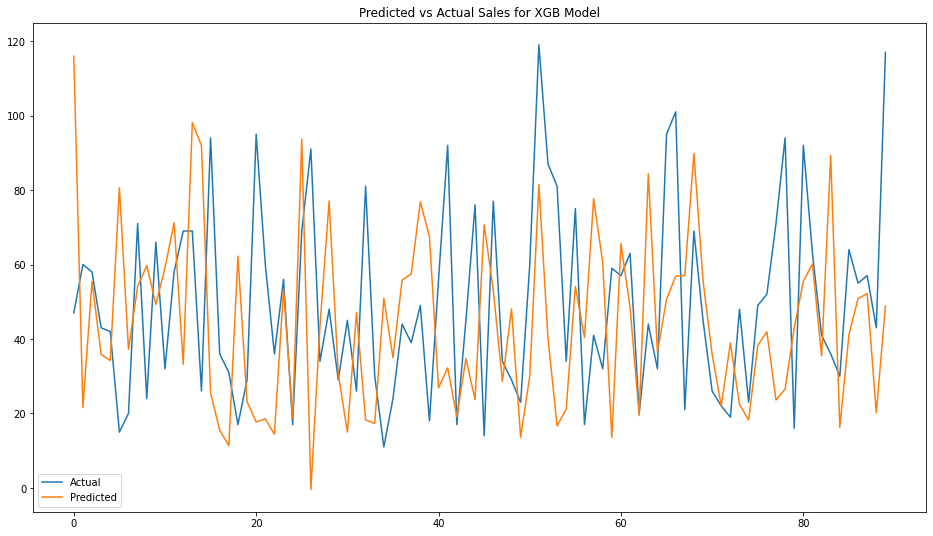

In [280]:
plot_pred_vs_act(xgb_eval_y.to_numpy()[-90:],xgb_predictions.to_numpy()[-90:],'XGB')

In [245]:
# Prepare test data for forecast
preprocessed_test_data = data_preprocessing(test,
                                            conf['DATA_COLS'],
                                            conf['GROUPED_COLS'],
                                            conf['LABEL_COL'],
                                            conf['INDEX_COL'])

In [248]:
xgb_test_data = feature_engineering(preprocessed_test_data, conf['INDEX_COL'])


In [256]:
# Get predictions from XGBoost model
xgb_test_dmat = xgb.DMatrix(xgb_test_data.drop(f'{conf["INDEX_COL"]}', axis=1))
xgb_forecast = pd.Series(xgb_model.predict(xgb_test_dmat))


In [263]:
xgb_forecast

0        12.327606
1        13.434913
2        13.329628
3        15.018339
4        14.956748
           ...    
44995    67.717598
44996    68.393845
44997    73.310265
44998    80.043770
44999    84.259163
Length: 45000, dtype: float32

In [264]:
result_xgb = deepcopy(test)

result_xgb[f'{conf["LABEL_COL"]}'] = xgb_forecast.to_numpy()
result_xgb

,id,store,item,sales
date,,,,
2018-01-01,0,1,1,12.327606
2018-01-02,1,1,1,13.434913
2018-01-03,2,1,1,13.329628
2018-01-04,3,1,1,15.018339
2018-01-05,4,1,1,14.956748
...,...,...,...,...
2018-03-27,44995,10,50,67.717598
2018-03-28,44996,10,50,68.393845
2018-03-29,44997,10,50,73.310265


<h1> Comparing the models' metrics </h1>

In [258]:
print(f'XGB SMAPE- {xgb_smape}%')
print(f'LSTM SMAPE- {lstm_smape}%')

print(f'XGB MSE- {xgb_mse:.2f}')
print(f'LSTM MSE- {lstm_mse:.2f}')

XGB SMAPE- 15.22%
LSTM SMAPE- 13.85%
XGB MSE- 68.03
LSTM MSE- 0.12


<h1> Plotting predictions for next 90 days for LSTM vs XGB </h1>

Text(0.5, 1.0, 'Comparing XGB vs LSTM for out of sample predictions for store 1 item 1')

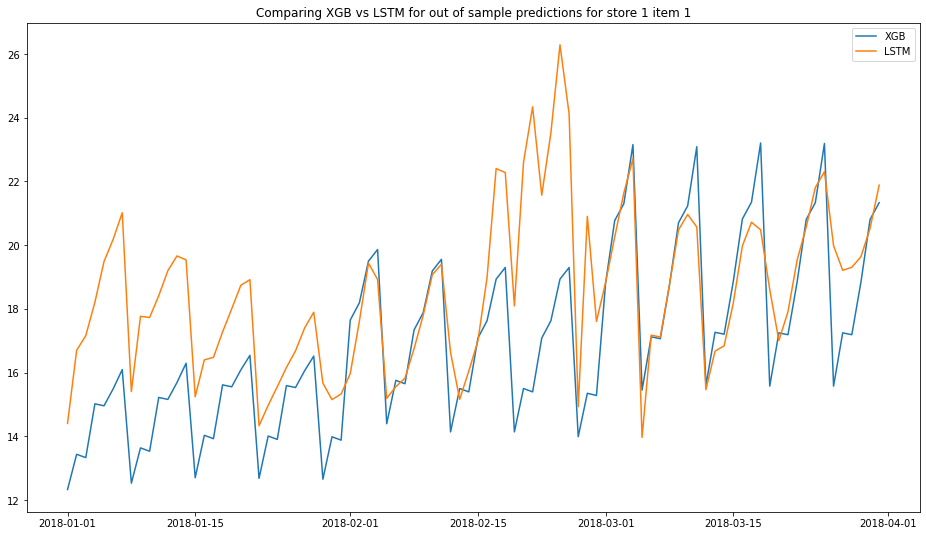

In [269]:
plt.plot(result_xgb[f'{conf["LABEL_COL"]}'][:90], label='XGB')
plt.plot(result_lstm[f'{conf["LABEL_COL"]}'][:90], label='LSTM')
plt.legend()
plt.title('Comparing XGB vs LSTM for out of sample predictions for store 1 item 1')

Text(0.5, 1.0, 'Comparing XGB vs LSTM for out of sample predictions for store 1 item 2')

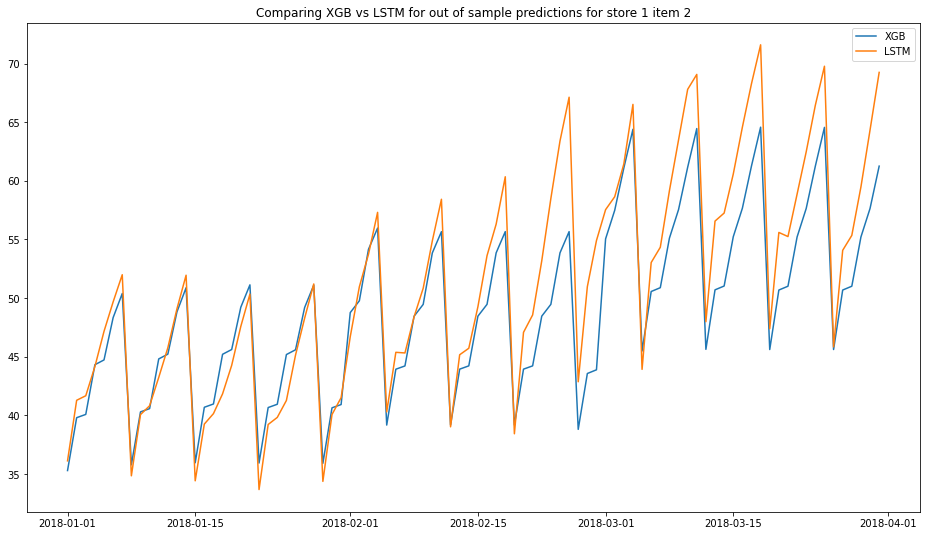

In [270]:
plt.plot(result_xgb[f'{conf["LABEL_COL"]}'][90:180], label='XGB')
plt.plot(result_lstm[f'{conf["LABEL_COL"]}'][90:180], label='LSTM')
plt.legend()
plt.title('Comparing XGB vs LSTM for out of sample predictions for store 1 item 2')

Text(0.5, 1.0, 'Comparing XGB vs LSTM for out of sample predictions for store 11 item 2')

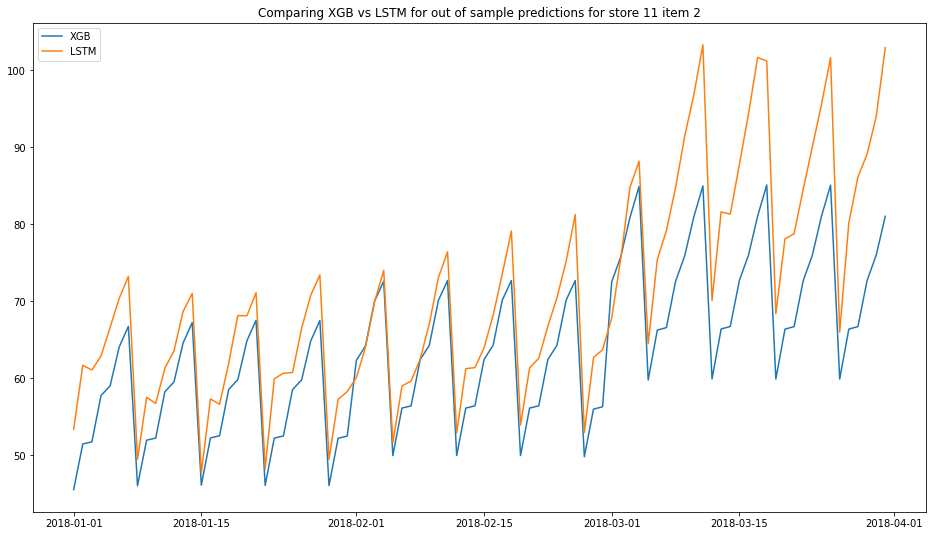

In [273]:
plt.plot(result_xgb[f'{conf["LABEL_COL"]}'][4590:4680], label='XGB')
plt.plot(result_lstm[f'{conf["LABEL_COL"]}'][4590:4680], label='LSTM')
plt.legend()
plt.title('Comparing XGB vs LSTM for out of sample predictions for store 11 item 2')